## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.

* **To be submitted within 2 weeks**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\Victoria\enpc\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Download the Model
We provide you a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [2]:
resnet34 = models.resnet34(pretrained=True)
resnet34.eval() # set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)

In [3]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [4]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [5]:
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them

import os
#os.mkdir("data", exists_ok=True)
#os.mkdir("data/TP2_images", exists_ok=True)
#!mv TP2_images/*  data/TP2_images/
#!cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2022/TP2/TP2_images.zip" && unzip TP2_images.zip
dir_path = "data/" 
dataset = preprocess_image(dir_path)

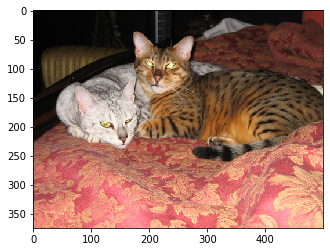

In [6]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

In [7]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [285 281 282] ['Egyptian cat', 'tabby, tabby cat', 'tiger cat']
Raw class scores: [13.077123  10.977326  10.5543785]


### Grad-CAM 
* **Overview:** Given an image, and a category (â€˜tiger catâ€™) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model resnet34 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. 
 + The size of feature maps is 7x7, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

![Grad-CAM](https://da2so.github.io/assets/post_img/2020-08-10-GradCAM/2.png)

In [8]:
class VerboseResnet(nn.Module):
    
    def __init__(self, model):
        super(VerboseResnet, self).__init__()
        #self.model = models.resnet34(pretrained=True)
        self.model = model
        # Add hook on the last COnv layer
        self.out = None
        self.activation_grad = None
        self.add_hooks()
        
    @staticmethod
    def hook_fd(self, input, output):
        global out
        out = output.detach()
        self.out = out

    @staticmethod
    def hook_bd(self, grad_input, grad_output):
        global activation_grads
        activation_grads = grad_output[0].detach()
        self.activation_grad = activation_grads
        
    def add_hooks(self):
        front_hook = self.model.layer4[2].conv2.register_forward_hook(self.hook_fd)
        back_hook = self.model.layer4[2].conv2.register_backward_hook(self.hook_bd)
    
    def forward(self, x):
        return self.model(x)
  

In [9]:
def grad_cam(image, model, class_index):
    # We forward through the model in order to activate forward hook
    output = model(image.view(1, 3, 224, 224))

    # We backprop the gradient corresponding to the class
    output[:, class_index].backward()
    grad = activation_grads

    # We take the average of the gradients wrt height and width
    alpha_c_k = torch.mean(activation_grads, dim=[0, 2, 3])

    # We build the linear combination with the heatmaps Ak
    image_result = torch.zeros((1, out.shape[2], out.shape[3]))
    for channel_id in range(out.shape[1]):
        image_result += out[:, channel_id, :, :] * alpha_c_k[channel_id]

    relu = nn.ReLU()
    image_result = relu(image_result)

    return image_result

        
        

In [10]:
batch_size, c, h, w = 1, 1, 7, 7
x  = torch.randn(batch_size, c, h, w)

y = F.interpolate(x, size=(300,200))
print(y.shape)

torch.Size([1, 1, 300, 200])


In [11]:
import cv2
from copy import deepcopy

def convert_bgr_to_rgb(image):
    h, w = image.shape[:2]
    new_image = deepcopy(image)
    new_image[:, :, 0], new_image[:, :, 2] = image[:, :, 2], image[:, :, 0]
    return new_image

def visualize_grad_cam(img, grad_cam_heatmap, fig_title, class_idx, ax, intensity=0.2):
    
    # Load initial image
    img = cv2.imread(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get original image shape
    #img = img.permute(1, 2, 0).numpy()
    H, W = img.shape[:2]
    
    # Post process the obtained heatmap (tensor to resized array)
    cam_channel, cam_h, cam_w = grad_cam_heatmap.shape
    #heatmap = torch.zeros((1, cam_channel, cam_h, cam_w))
    #heatmap[0, :, :, :] = grad_cam_heatmap
    #heatmap = torch.nn.functional.interpolate(heatmap, size=(H, W)).numpy()[0, 0, :, :]
    
    # Normalizing the heatmap
    heatmap = cv2.resize(grad_cam_heatmap.squeeze().numpy(), (W, H))
    
    heatmap = cv2.normalize(heatmap, heatmap, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    #print('heatmap  minmax', np.max(heatmap), np.min(heatmap))
    # Applying a colormap to heatmap
    #heatmap = cv2.applyColorMap(np.uint8(255 * (255 - heatmap)), cv2.COLORMAP_JET)
    heatmap = cv2.applyColorMap(np.uint8(255 - heatmap), cv2.COLORMAP_JET)
    
    final_image = np.uint8((1 - intensity) * img + intensity * heatmap)
    #print(np.max(final_image), np.min(final_image))

    #ax[class_idx].imshow(img, cmap=ListedColormap(list(heatmap)))
    ax[class_idx].imshow(final_image)
    ax[class_idx].set_title(fig_title)
    
    

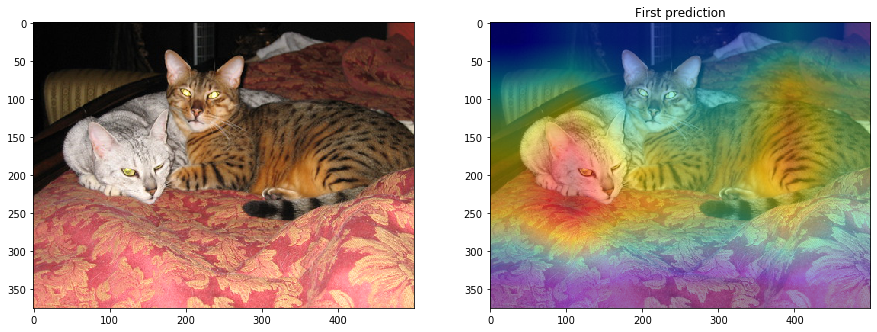

In [19]:
test_model = VerboseResnet(model=resnet34)
image_result = grad_cam(dataset[5][0], test_model, 285)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(input_image)
visualize_grad_cam(dataset.imgs[5][0], image_result, 'First prediction', 1, ax, intensity=0.4)
plt.show()

In [13]:
def apply_grad_cam_to_all(dataset, model, n_top_classes=3):
    
    for image_idx in range(len(dataset)):
        
        image = dataset[image_idx][0]
        
        # Get best classes predicted
        output = model(image.view(1, 3, 224, 224))
        top_classes_values, top_classes_indices = torch.topk(output, n_top_classes)
        
        # Apply GradCam for each class
        index_order= 1
        fig, ax = plt.subplots(1, n_top_classes, figsize=(15, 15))
        for class_index in top_classes_indices[0].numpy():
            class_name = classes[class_index]
        
            # Show the resulting images
            heatmap = grad_cam(image, model, class_index)
            
            fig_title = '{} most likely prediction: {}'.format(index_order, class_name)
            visualize_grad_cam(dataset.imgs[image_idx][0], heatmap, fig_title, index_order - 1, ax, intensity=0.3)
            
            index_order += 1
            
        plt.show()
            

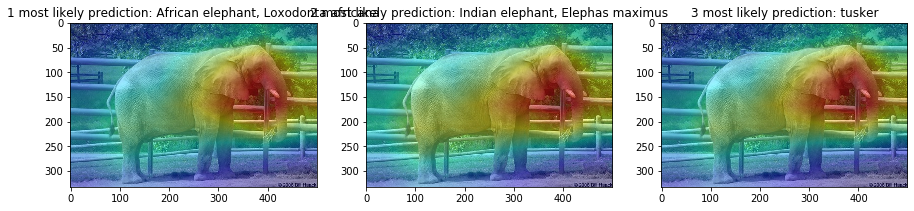

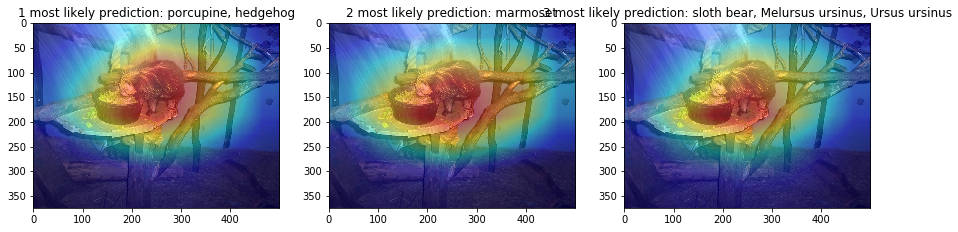

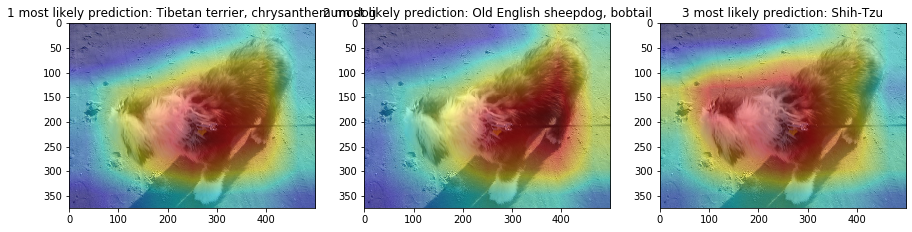

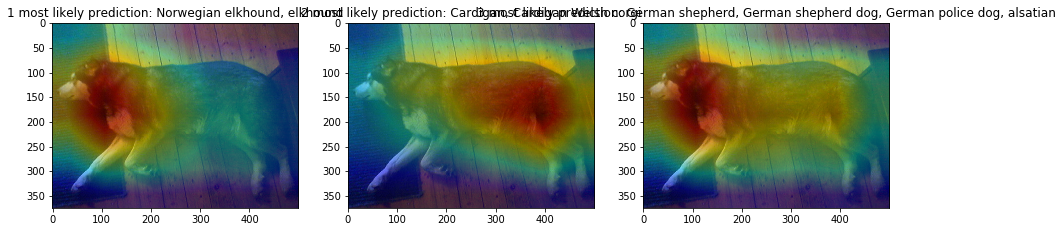

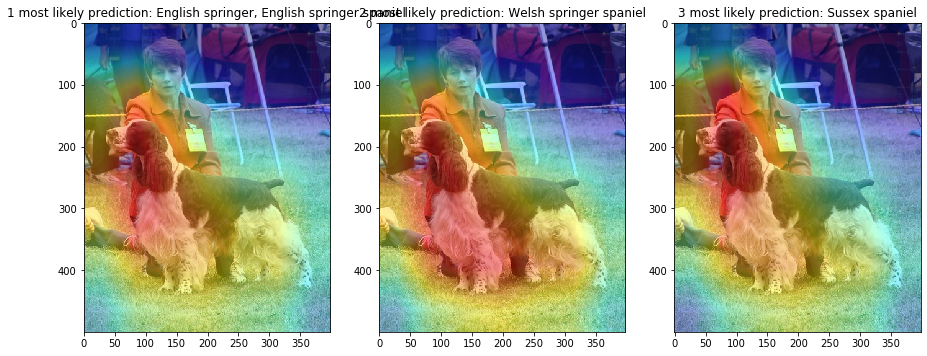

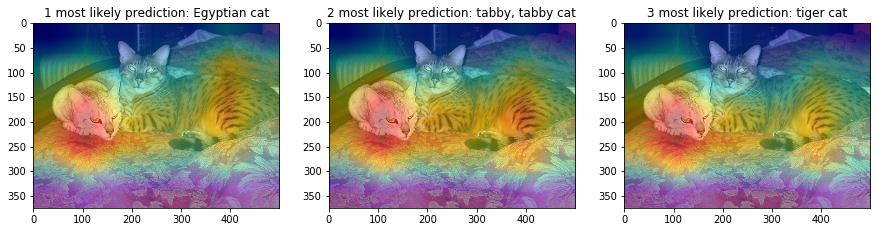

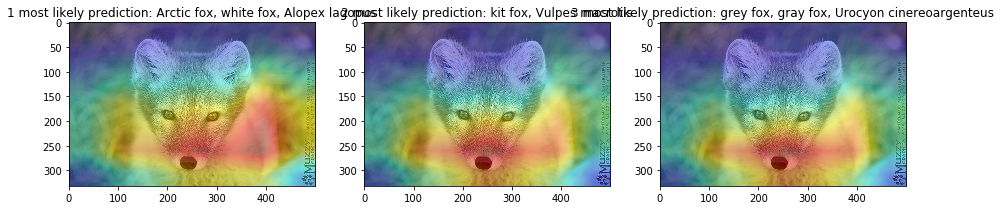

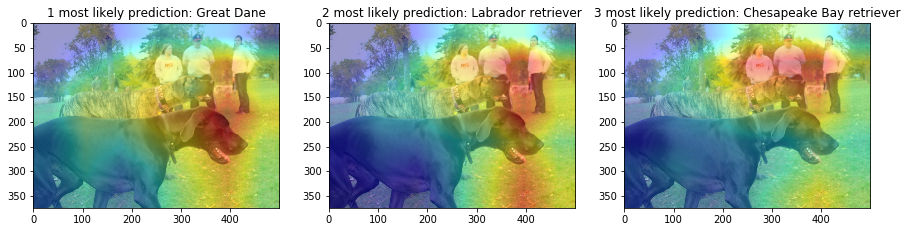

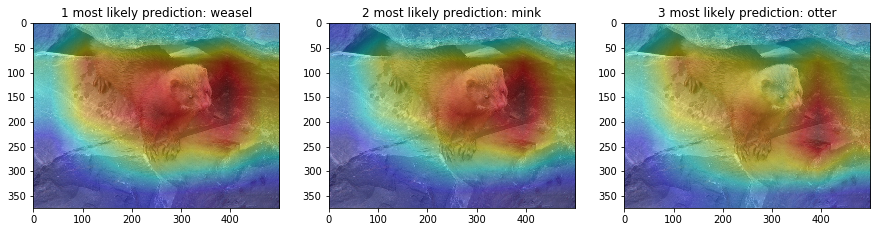

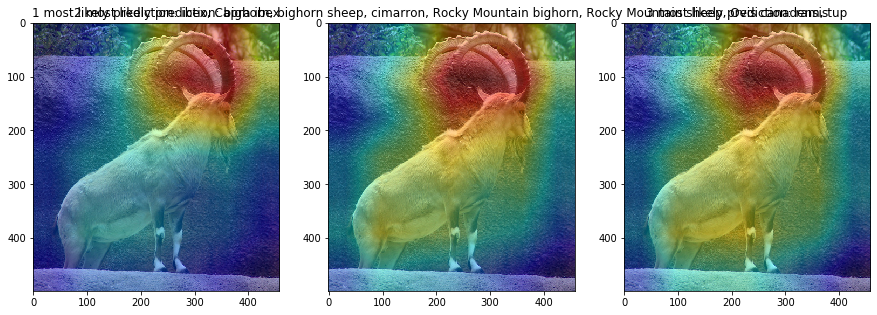

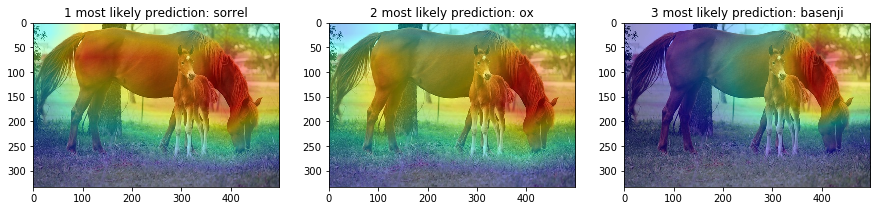

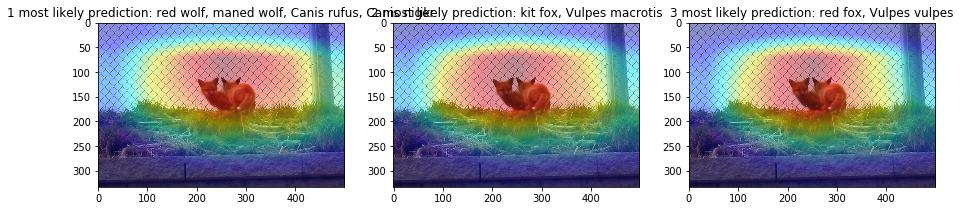

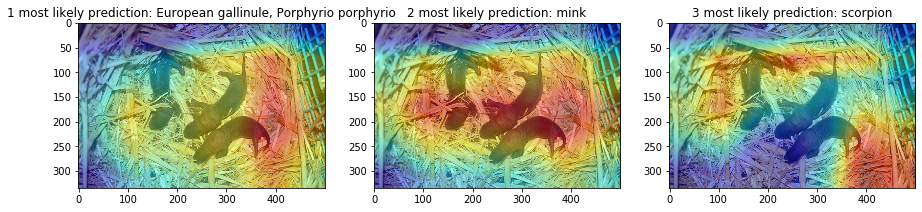

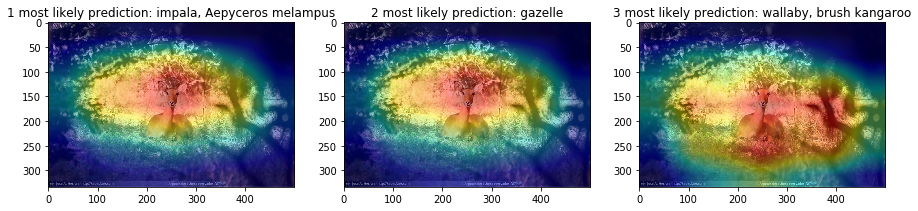

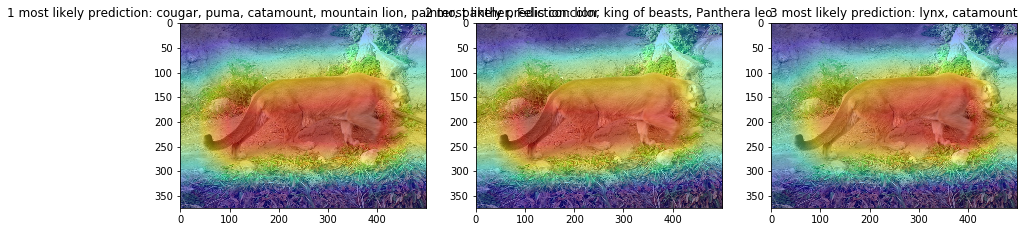

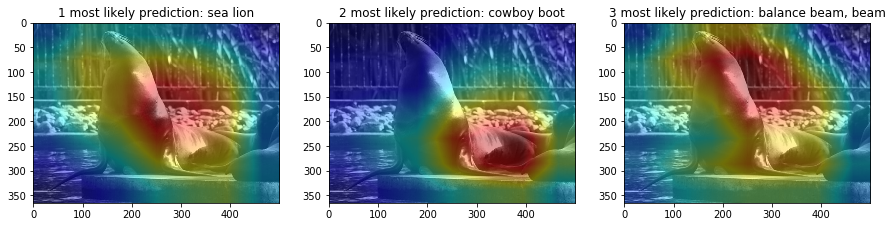

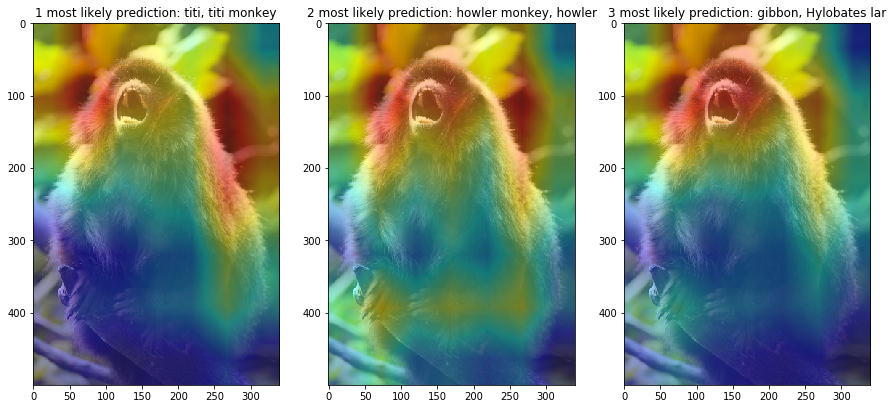

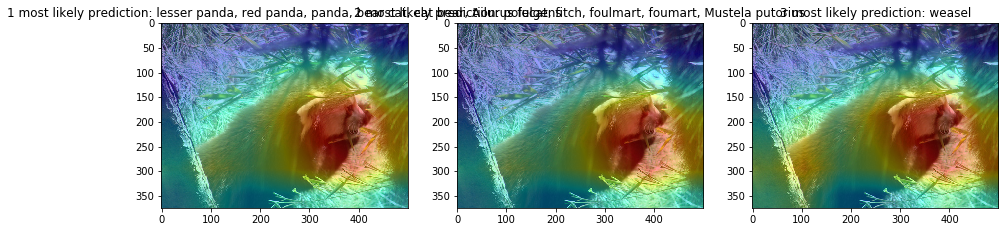

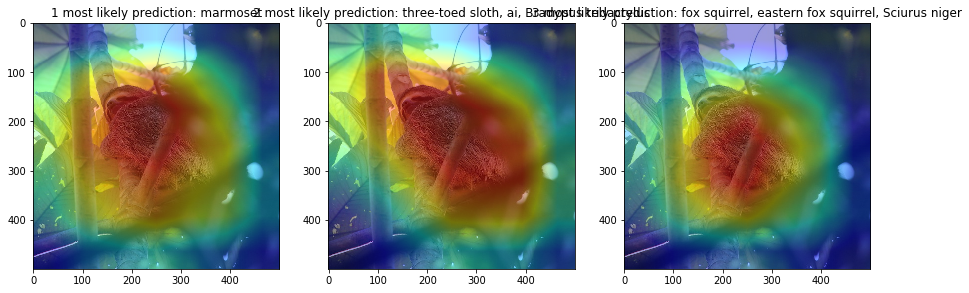

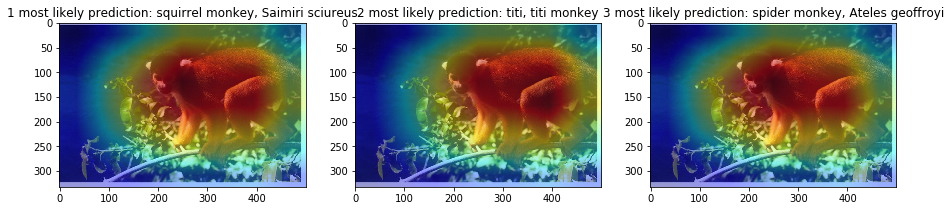

In [14]:
apply_grad_cam_to_all(dataset, test_model, n_top_classes=3)